In [1]:
import ee
import geemap
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium import Choropleth
import gdown
import shutil
from osgeo import gdal

In [4]:
# Step 0: Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

In [5]:
# Define AOI for Puerto Rico (for Hurricane Maria)
aoi = ee.Geometry.Polygon([
    [[-67.3, 17.9], [-65.2, 17.9], [-65.2, 18.6], [-67.3, 18.6], [-67.3, 17.9]]
])
puerto_rico = ee.FeatureCollection('FAO/GAUL/2015/level2') \
    .filter(ee.Filter.eq('ADM0_NAME', 'Puerto Rico'))

In [6]:
# Step 1: Sentinel-1 SAR Pre/Post Flood
# ----------------------------
before = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate('2017-09-10', '2017-09-15') \
    .filterBounds(aoi) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV') \
    .mean()

after = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate('2017-09-22', '2017-09-28') \
    .filterBounds(aoi) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV') \
    .mean()

In [7]:
# Speckle Filtering
def apply_speckle_filter(image):
    return image.focal_mean(radius=50, kernelType='circle', iterations=1)

before_filtered = apply_speckle_filter(before)
after_filtered = apply_speckle_filter(after)

In [8]:
# Backscatter Difference and Thresholding
delta = after_filtered.subtract(before_filtered)
flood = delta.lt(-2.5)


In [9]:
# Remove Permanent Water
jrc_water = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
permanent_water = jrc_water.gt(90)
refined_flood = flood.And(permanent_water.Not())


In [10]:
# Topographic Filtering
dem = ee.Image('USGS/SRTMGL1_003')
slope = ee.Terrain.slope(dem)
slope_mask = slope.lt(5)
realistic_flood = refined_flood.updateMask(slope_mask)


In [11]:
# Estimate Water Surface Level
flood_dem = dem.updateMask(realistic_flood)
water_level = flood_dem.reduceRegion(
    reducer=ee.Reducer.percentile([90]),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).get('elevation')

In [12]:
# Compute Flood Depth
depth_image = ee.Image.constant(water_level).subtract(dem).updateMask(realistic_flood).rename('flood_depth')

In [13]:
# Step 2: Export Flood Depth Raster

out_file = 'PuertoRico_Flood_Depth_Maria2017.tif'
geemap.ee_export_image_to_drive(
    image=depth_image,
    description='PuertoRico_Flood_Depth_Maria2017',
    folder='GEE_Flood_Exports',
    region=aoi,
    scale=30
)
print("Export task started. Check the GEE Tasks tab.")

Export task started. Check the GEE Tasks tab.


In [19]:
task_status = ee.batch.Task.list()
for t in task_status:
    print(t.status())


{'state': 'COMPLETED', 'description': 'PuertoRico_Flood_Depth_Maria2017', 'priority': 100, 'creation_timestamp_ms': 1744060236616, 'update_timestamp_ms': 1744062085443, 'start_timestamp_ms': 1744060243047, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1hkzLhwt2sQ2MW-1XtyjZpIKMzjSxD2D_'], 'attempt': 1, 'batch_eecu_usage_seconds': 61973.859375, 'id': 'K4VMUKQ4SWSHGFCOUSVPVZFZ', 'name': 'projects/poststorm/operations/K4VMUKQ4SWSHGFCOUSVPVZFZ'}


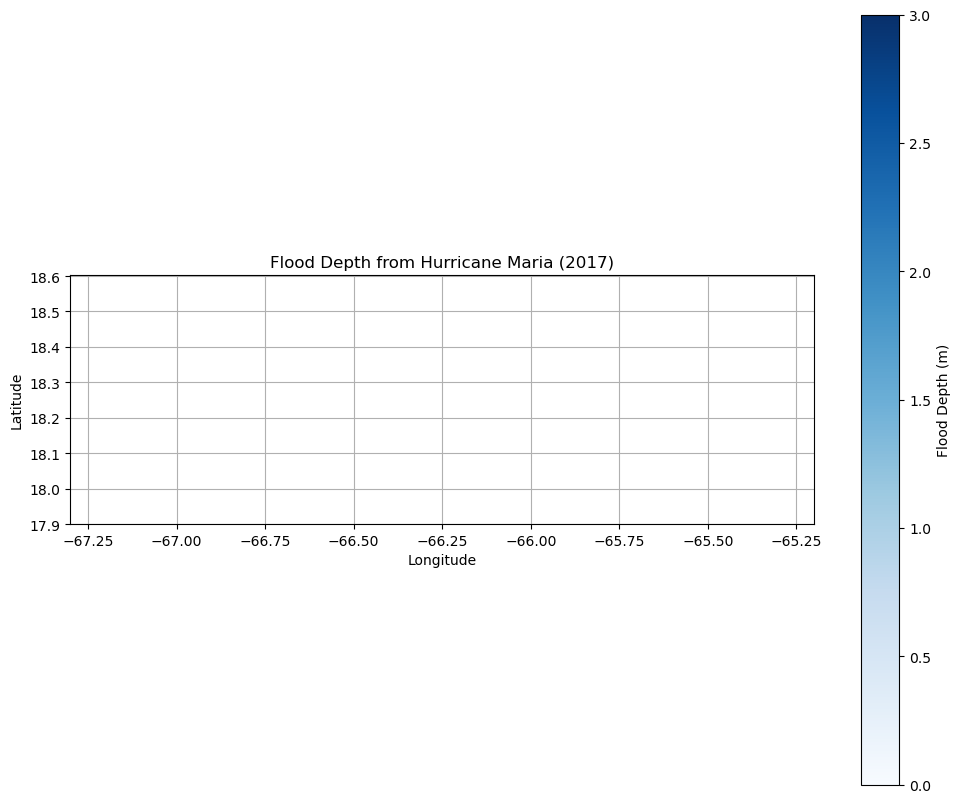

In [24]:
# Step 3: Load and Visualize Raster (after manual download from Drive)
out_file = r"C:\Users\hanis\Downloads\PuertoRico_Flood_Depth_Maria2017.tif"

with rasterio.open(out_file) as src:
    depth = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Mask and visualize
masked_depth = np.ma.masked_invalid(np.where(depth <= 0, np.nan, depth))

plt.figure(figsize=(12, 10))
cax = plt.imshow(masked_depth, cmap='Blues', vmin=0, vmax=3, extent=extent)
plt.colorbar(cax, label='Flood Depth (m)')
plt.title('Flood Depth from Hurricane Maria (2017)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Raster shape: (2609, 7794)
Raster min/max: -10.0 8.0
Valid flood depth pixels: 1763


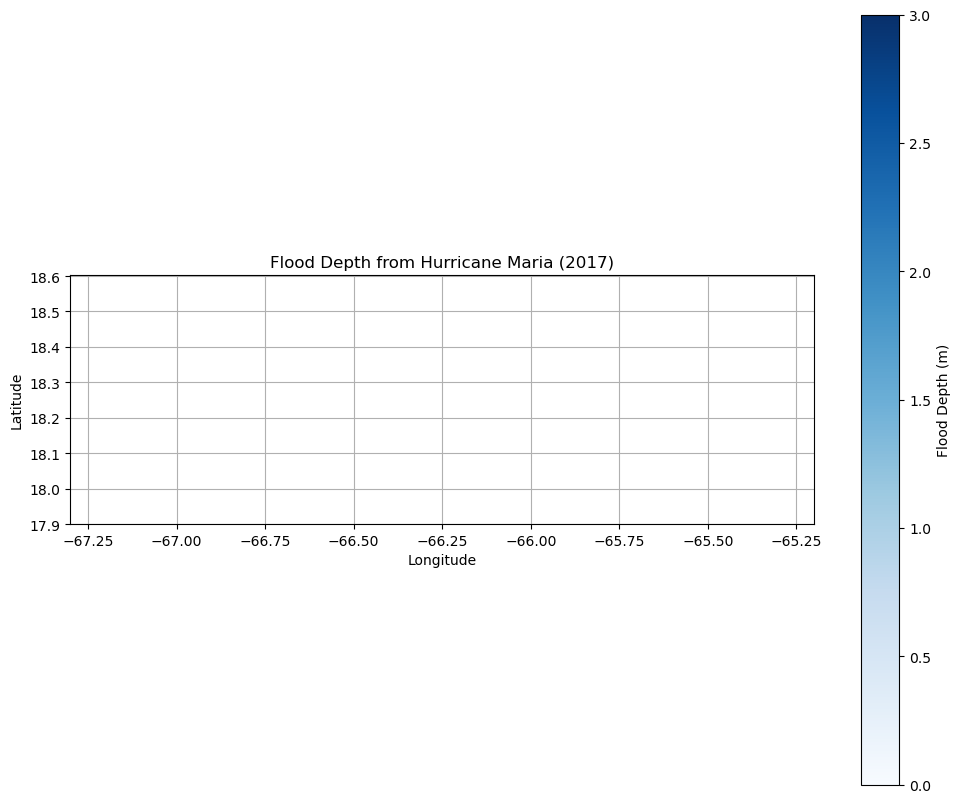

In [25]:
out_file = r"C:\Users\hanis\Downloads\PuertoRico_Flood_Depth_Maria2017.tif"
with rasterio.open(out_file) as src:
    depth = src.read(1)
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

print("Raster shape:", depth.shape)
print("Raster min/max:", np.nanmin(depth), np.nanmax(depth))

# Check how many valid depth values exist
valid_pixels = np.sum(depth > 0)
print("Valid flood depth pixels:", valid_pixels)

# Mask and visualize only if valid data exists
if valid_pixels > 0:
    masked_depth = np.ma.masked_invalid(np.where(depth <= 0, np.nan, depth))

    plt.figure(figsize=(12, 10))
    cax = plt.imshow(masked_depth, cmap='Blues', vmin=0, vmax=3, extent=extent)
    plt.colorbar(cax, label='Flood Depth (m)')
    plt.title('Flood Depth from Hurricane Maria (2017)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Warning: No non-zero flood depth values found in the raster. Check GEE export and filters.")
